In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from environment import BCI2DCursorEnv  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ==============================
#   Dueling Double DQN Network
# ==============================
class DuelingQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.adv_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value_stream(x)
        adv = self.adv_stream(x)
        q = value + (adv - adv.mean(dim=1, keepdim=True))
        return q


# ==============================
#   Replay Buffer
# ==============================
from collections import deque
class ReplayBuffer:
    def __init__(self, capacity=8000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, ns, d):
        self.buffer.append((s, a, r, ns, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, ns, d = zip(*batch)
        return (
            torch.tensor(np.array(s), dtype=torch.float32, device=device),
            torch.tensor(a, dtype=torch.long, device=device),
            torch.tensor(r, dtype=torch.float32, device=device),
            torch.tensor(np.array(ns), dtype=torch.float32, device=device),
            torch.tensor(d, dtype=torch.float32, device=device)
        )
    
    def __len__(self):
        return len(self.buffer)

# ==============================
#   Epsilon-Greedy Policy
# ==============================
def epsilon_greedy(q_net, state, epsilon, env):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            q_values = q_net(state_t)
            return int(torch.argmax(q_values))


# ==============================
#   Double DQN Update
# ==============================
def update_q(q_net, target_net, optimizer, batch, gamma=0.9):
    s, a, r, ns, d = batch

    with torch.no_grad():
        na = q_net(ns).argmax(1, keepdim=True)
        nq = target_net(ns).gather(1, na).squeeze(1)
        target = r + gamma * (1 - d) * nq

    q = q_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
    loss = F.mse_loss(q, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_success(env, q_net, episodes=50):
    q_net.eval()
    success = 0
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        while not done:
            with torch.no_grad():
                a = int(torch.argmax(q_net(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0))))
            next_state, reward, done, _, _ = env.step(a)
            state = next_state
            if done and np.linalg.norm(env.cursor_pos - env.target_pos) < env.success_radius:
                success += 1

    return success / episodes * 100



In [ ]:
def train_dqn_with_checkpoints(
        train_env,
        val_env,
        test_id_env,
        test_ood_env,
        mode_name="Hybrid",
        num_episodes=1000,
        gamma=0.9, lr=1e-4,
        eps_start=1.0, eps_end=0.05, eps_decay=0.995,
        batch_size=128, sync_interval=10, ckpt_interval=20):

    # ==== Init network ====
    s, _ = train_env.reset()
    state_dim, action_dim = np.prod(s.shape), train_env.action_space.n
    q_net = DuelingQNetwork(state_dim, action_dim, hidden_dim=256).to(device)
    target_net = DuelingQNetwork(state_dim, action_dim, hidden_dim=256).to(device)
    target_net.load_state_dict(q_net.state_dict())

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    buf = ReplayBuffer()

    eps = eps_start
    train_rewards = []
    ckpt_eps = []
    val_success_curve = []
    test_id_success_curve = []
    test_ood_success_curve = []

    for ep in range(1, num_episodes + 1):
        s, _ = train_env.reset()
        done, total_r = False, 0

        while not done:
            a = epsilon_greedy(q_net, s, eps, train_env)
            ns, r, done, _, _ = train_env.step(a)
            buf.push(s, a, r, ns, done)

            s, total_r = ns, total_r + r

            if len(buf) > batch_size:
                batch = buf.sample(batch_size)
                update_q(q_net, target_net, optimizer, batch, gamma)

        # decay epsilon
        eps = max(eps_end, eps * eps_decay)
        train_rewards.append(total_r)

        # sync target net
        if ep % sync_interval == 0:
            target_net.load_state_dict(q_net.state_dict())

        # ========== Checkpoints ==========
        if ep % ckpt_interval == 0:
            ckpt_eps.append(ep)

            torch.save(q_net.state_dict(), f"models/checkpoint_ep{ep}.pth")

            val_s = evaluate_success(val_env, q_net, episodes=50)
            test_id_s = evaluate_success(test_id_env, q_net, episodes=50)
            test_ood_s = evaluate_success(test_ood_env, q_net, episodes=50)

            val_success_curve.append(val_s)
            test_id_success_curve.append(test_id_s)
            test_ood_success_curve.append(test_ood_s)

            print(f"[Ep {ep}] TrainR={np.mean(train_rewards[-10:]):.2f} | "
                  f"VAL={val_s:.1f}% | Test-ID={test_id_s:.1f}% | Test-OOD={test_ood_s:.1f}%")

    return train_rewards, ckpt_eps, val_success_curve, test_id_success_curve, test_ood_success_curve

def plot_curves(train_rewards, ckpt_eps, val_s, test_id_s, test_ood_s):
    plt.figure(figsize=(10,6))

    plt.plot(train_rewards, label="Train Reward", alpha=0.5)

    plt.plot(ckpt_eps, val_s, 'o-', label="Val (OOD) Success", color='red')
    plt.plot(ckpt_eps, test_id_s, 'o-', label="Test (ID) Success", color='green')
    plt.plot(ckpt_eps, test_ood_s, 'o-', label="Test (OOD) Success", color='blue')

    plt.xlabel("Episode")
    plt.ylabel("Value")
    plt.legend()
    plt.title("Training Reward + Validation/Test Success Curves")
    plt.grid(True)
    plt.show()


/user/yzhong9/RL_Final_Project/environment.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location='cpu'))


 SL : models/pooled_eegnet_best.pth
 Hybrid : (220, 992)
 SL : models/pooled_eegnet_best.pth
 Hybrid : (576, 992)
 SL : models/pooled_eegnet_best.pth
 Hybrid : (220, 992)
 SL : models/pooled_eegnet_best.pth
 Hybrid : (576, 992)
[Ep 20] TrainR=0.23 | VAL=38.0% | Test-ID=8.0% | Test-OOD=32.0%
[Ep 40] TrainR=2.54 | VAL=44.0% | Test-ID=40.0% | Test-OOD=60.0%
[Ep 60] TrainR=3.01 | VAL=80.0% | Test-ID=84.0% | Test-OOD=90.0%
[Ep 80] TrainR=1.51 | VAL=94.0% | Test-ID=96.0% | Test-OOD=90.0%
[Ep 100] TrainR=15.49 | VAL=86.0% | Test-ID=92.0% | Test-OOD=84.0%
[Ep 120] TrainR=10.79 | VAL=90.0% | Test-ID=92.0% | Test-OOD=96.0%
[Ep 140] TrainR=22.92 | VAL=88.0% | Test-ID=94.0% | Test-OOD=88.0%
[Ep 160] TrainR=42.40 | VAL=86.0% | Test-ID=98.0% | Test-OOD=80.0%
[Ep 180] TrainR=48.65 | VAL=96.0% | Test-ID=92.0% | Test-OOD=94.0%
[Ep 200] TrainR=24.92 | VAL=86.0% | Test-ID=100.0% | Test-OOD=86.0%
[Ep 220] TrainR=36.92 | VAL=82.0% | Test-ID=100.0% | Test-OOD=92.0%
[Ep 240] TrainR=49.89 | VAL=80.0% | Test-I

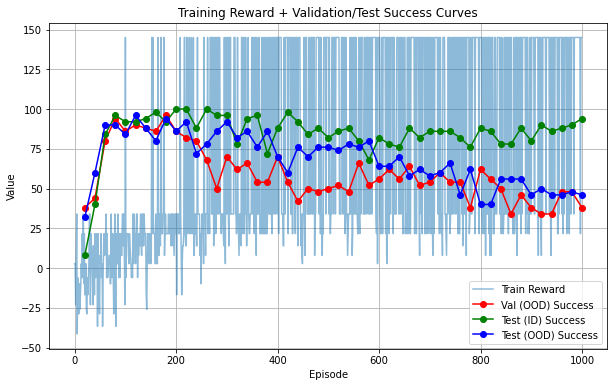

In [3]:
# ========== Load datasets ==========
train_data = np.load("data_sequences/test_id_5subj_segments.pkl", allow_pickle=True)
val_data = np.load("data_sequences/val_ood_2subj_segments.pkl", allow_pickle=True)
test_id_data = np.load("data_sequences/test_id_5subj_segments.pkl", allow_pickle=True)
test_ood_data = np.load("data_sequences/test_ood_2subj_segments.pkl", allow_pickle=True)

train_env = BCI2DCursorEnv(train_data["segments"], train_data["labels"],
                           "models/pooled_eegnet_best.pth",
                           feature_npz_path="features_SL/test_id.npz",
                           method='hybrid')

val_env = BCI2DCursorEnv(val_data["segments"], val_data["labels"],
                         "models/pooled_eegnet_best.pth",
                         feature_npz_path="features_SL/val_ood.npz",
                         method='hybrid')

test_id_env = BCI2DCursorEnv(test_id_data["segments"], test_id_data["labels"],
                             "models/pooled_eegnet_best.pth",
                             feature_npz_path="features_SL/test_id.npz",
                             method='hybrid')

test_ood_env = BCI2DCursorEnv(test_ood_data["segments"], test_ood_data["labels"],
                              "models/pooled_eegnet_best.pth",
                              feature_npz_path="features_SL/test_ood.npz",
                              method='hybrid')

# ========== Train + collect curves ==========
train_rewards, ckpt_eps, val_s, test_id_s, test_ood_s = train_dqn_with_checkpoints(
    train_env, val_env, test_id_env, test_ood_env,
    num_episodes=1000, mode_name="Hybrid"
)

# ========== Plot ==========
plot_curves(train_rewards, ckpt_eps, val_s, test_id_s, test_ood_s)

